In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue 17 June, 2025

Generate new hybrid coordinates to feed into the CAM model for the DCMIP 2025
test cases.

Assumes p0=ps to create coefficients.

For Case 1, a vertical grid with a linear increase in vertical
spacing in the first 21 km to a maximum vertical spacing which
remains constant until the model top. Assumes an atmosphere
with a constant lapse rate for the troposphere and stratosphere.

For Case 2, we generate a vertical grid constant minimum spacing dz_min over the 
topography, a linear increase in spacing until 21 km to a max spacing dz_max, 
and a constant spacing of dz_max up to the model top. Assumes a hydrostatic,
isothermal atmosphere.

For Case 3, we generate a vertical grid with uniform spacing up to the model top
assuming either (1) an atmopshere with a constant lapse rate temperature profile
or (2) a troposphere with constant lapse rate and an isothermal stratosphere.

@author: Nicholas Androski (nandroski), Tim Andrews (ta440), and Owen Hughes
affiliation: University of Michigan
contact: nandrosk@umich.edu
"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # gives a progress bar to loops
from functools import partial

# Hybrid Coefficient Workflow:
The hybrid $\eta$ coordinate system combines a pressure and a sigma based coordinate system to create a flexible, terrain-following coordinate. By definition it guarantees $p(\eta=\eta_\text{top})=p_\text{top}$ and $p(\eta=1) = p_s$.

Hybrid coefficients are defined such that:
$$ p(\eta) = A(\eta)\cdot p_0 + B(\eta)\cdot p_s$$
We use the hybrid coefficients suggested by Laprise and Girard (1990): 
$$ A(\eta) = \eta - B(\eta)$$
$$ B(\eta) = \bigg(\frac{\eta -\eta_\text{top}}{1-\eta_\text{top}}\bigg)^c$$
where $\eta_\text{top}$ corresponds to the model top height $(z_\text{top}$) or equivalent the model top pressure ($p_\text{top}$).If $p_s=p_0$ (at least initially), then the equations simplify to $\eta = p/p_s$ and $\eta_\text{top}=p(z_\text{top})/p_s$. The exponent $c$ defines the degree of transition between sigma cordinates near the surface and a pressure coordinate near the top. Higher values of $c$ give a more gradual transition. We use $c=1$ for all of our vertical coordinates, however other values can be used given the application.

1. Assume an atmospheric profile to relate pressure and height, i.e. derive a p(z) function for your given application.
  * Often this is a hydrostatically balanced atmosphere which requires a prescribed temperature profile to compute p from z:
  $$ p = p_s\exp\bigg({-\int_{z_s}^{z} \frac{g}{R_dT}dz}\bigg)$$
  * The actual p(z) function for a given application may be extremely complicated and may not have an analytic form. Often we can make a simple, idealized model of this profile to produce coefficients that will have vertical spacing and a model top nearby but not exactly at our specifications. If our profile is too ideal, then we can end up with a vertical grid that differs greatly in the spacing and model top height that we intended.

2. Provide an array of interface heights, $z_i$. Some important parameters include
  * Model top height
  * Number of levels
  * Uniform or non-uniform spacing
  * If spacing is non-uniform where should vertical spacing be its smallest to resolve the phenomenon of your given application?
3. Compute the pressure at the given interface heights.
4. Assuming $p_s=p_0$, compute $\eta$ and $\eta_\text{top}$ at the interface levels:
  $$\eta_i = p_i/p_0 = p(z_i)/p_0$$
  $$\eta_\text{top} = p(z_\text{top})/p_0$$
5. Compute the hybrid coefficients at interface heights:
  $$ \text{hybi}=B(\eta_i) = \bigg(\frac{\eta_i -\eta_\text{top}}{1-\eta_\text{top}}\bigg)^c$$
  $$ \text{hyai}=A(\eta_i) = \eta_i-B(\eta_i)$$
6. Compute the eta and the hybrid coefficients at midpoint levels using a linear average. The total number of midpoint levels will always be one less than the total number of interface levels. When discussing the number of levels of a given vertical grid, the number refers to the number of **midpoint** levels.
7. CESM uses the variables lev and ilev for the midpoint coordinate levels and interface coordinate levels. These are simply $\eta$ scaled by 1000. In the special case that $p_0=p_s$, then lev or ilev represent the pressure at that level in hPa. 
$$\text{lev} = \eta_m\cdot 1000$$
$$\text{ilev} = \eta_i\cdot 1000$$

# Functions

In [2]:
def gen_coeff(z_i, p_from_z, p0 = 1e5, c = 1):
  '''
  Generates hybrid coefficients from interface heights using the 
  Laprise and Griard (1990) method where it is assumed p0 = ps.

  Inputs:
  -----------------------
  z_i      : array interface heights in meters (the largest z_i value is 
             assumed to the model top).
  p_from_z : A function that computes an array of pressure values in Pa for a 
             given array of height values in meters.
  p0       : A reference pressure in Pa. It is assumed ps = p0
  c        : (default 1) The degree of transition between sigma terrain
             following coordinates near the surface and pressure coordiantes
             near the model top. Higher values give a more gradual transition.


  Outputs
  -----------------------
  ilev: interface levels
  lev:  midpoint levels
  hyai: hybrid A coefficients at interface levels
  hybi: hybrid B coefficients at interface levels
  hyam: hybrid A coefficients at midpoint levels
  hybm: hybrid B coefficients at midpoint levels

  '''
  
  ###################################
  #           Interface η           #
  ###################################

  #compute eta using the given interface heights
  p_i = p_from_z(z_i)
  eta_i = p_i/p0
  eta_top_i = np.min(eta_i)

  ###################################
  #      Interface Coefficients     #
  ###################################


  # Compute coefficients for interace
  hybi = ( (eta_i-eta_top_i)/(1-eta_top_i) )**c
  hyai = eta_i - hybi

  ###################################
  #      Midpoint Coefficients      #
  ###################################

  # compute midpoint coefficients using linear average of
  # interface coefficients
  hyam = (hyai[1:]+hyai[:-1])/2
  hybm = (hybi[1:]+hybi[:-1])/2

  ###################################
  #          lev and ilev           #
  ###################################    

  ilev = eta_i * 1000 # hPa 
  eta_m = (eta_i[1:]+eta_i[:-1])/2
  lev = eta_m * 1000 # hPa

  return ilev,lev,hyai,hybi,hyam,hybm
  
  
def save_coeff_to_nc(ilev, lev, hyai, hybi, hyam, hybm, P0,
                           output_dir='', modname='',desc='Derived using ',
                           attribution='DCMIP 2025', creator = 'Nicholas Androski',
                           overwrite = False):
  '''
  Saves hybrid coefficients in CESM-friendly format. This file can be supplied
  to NCDATA to change the vertical grid used by the model. Requires the netCDF4
  library.
  '''
  from netCDF4 import Dataset
  import os.path
  from os import remove

  nlev = len(lev)

  if os.path.isfile(f"{output_dir}hybrid_p_L{int(nlev)}_{modname}.nc"):
      print(f'{output_dir}hybrid_p_L{int(nlev)}_{modname}.nc already exists')
      if overwrite:
          print('overwriting...')
          remove(f"{output_dir}hybrid_p_L{int(nlev)}_{modname}.nc")
      else:
          raise OSError(f"{output_dir}hybrid_p_L{int(nlev)}_{modname}.nc already exists. Change filename or turn overwrite to True.")
  ncfile = Dataset(f"{output_dir}hybrid_p_L{int(nlev)}_{modname}.nc",
                    mode='w',data_model="NETCDF3_CLASSIC")

  # Define dimensions
  lev_dim = ncfile.createDimension("lev", nlev)      # Fixed size
  ilev_dim = ncfile.createDimension("ilev", nlev+1)     # Fixed size

  # Create coordinate variables
  levs = ncfile.createVariable("lev", np.float32, ("lev",))
  ilevs = ncfile.createVariable("ilev", np.float32, ("ilev",))

  # reference variables
  P0_ = ncfile.createVariable("P0", np.float64)  # Scalar
  # PS_ = ncfile.createVariable("PS", np.float64, ("lev",))  # Surface pressure field

  # Create a data variable
  hyai_ = ncfile.createVariable("hyai", np.float32, ("ilev"), 
                                zlib=True, fill_value=-9999.0)
  hybi_ = ncfile.createVariable("hybi", np.float32, ("ilev"), 
                                zlib=True, fill_value=-9999.0)
  hyam_ = ncfile.createVariable("hyam", np.float32, ("lev"), 
                                zlib=True, fill_value=-9999.0)
  hybm_ = ncfile.createVariable("hybm", np.float32, ("lev"), 
                                zlib=True, fill_value=-9999.0)

  levs.A_var = "hyam"
  levs.B_var = "hybm"
  levs.P0_var = "P0"
  levs.PS_var = "PS"
  levs.bounds = "ilev"

  ilevs.A_var = "hyai"
  ilevs.B_var = "hybi"
  ilevs.P0_var = "P0"
  # ilevs.PS_var = "PS"
          

  # Add global attributes following NCAR conventions
  ncfile.title = f"L{nlev} Hybrid eta coefficients: p(i,j,k) = A(k) * P0 + B(k) * PS(i,j)"
  ncfile.institution = attribution
  ncfile.source = desc
  ncfile.history = "Created by " + Dataset.__dict__.get('__name__', creator)

  # Add variable attributes
  levs.units = "hybrid_sigma_pressure (hPa)"
  levs.long_name = "hybrid level at layer midpoints (1000*(A+B))" 

  levs.units = "hybrid_sigma_pressure (hPa)"
  levs.long_name = "hybrid level at layer interfaces (1000*(A+B))" 


  hyai_.long_name = "hybrid A coefficient at layer interfaces"
  hybi_.long_name = "hybrid B coefficient at layer interfaces"
  hyam_.long_name = "hybrid A coefficient at layer midpoints"
  hybm_.long_name = "hybrid B coefficient at layer midpoints"

  # Populate coordinate variables
  if lev[0]>lev[-1]:
      levs[:] = lev[::-1] #flip all the arrays so that levels go from low to high
      ilevs[:] = ilev[::-1]
  else:
      levs[:] = lev #flip all the arrays so that levels go from low to high
      ilevs[:] = ilev
      
      

  # Populate ref variables
  P0_.assignValue(P0) 

  # Populate coefficient variables
  if lev[0]>lev[-1]:
      hyai_[::] = hyai[::-1]
      hybi_[::] = hybi[::-1]
      hyam_[::] = hyam[::-1]
      hybm_[::] = hybm[::-1]
  else:
      hyai_[:] = hyai
      hybi_[:] = hybi
      hyam_[:] = hyam
      hybm_[:] = hybm
      

  # Close the NetCDF file
  ncfile.close()
  return

In [3]:
# p_from_z functions

def p_from_z_lapse_tropo(z,Gamma=7E-3,T0=300,PS=1e5,zs=0):
  '''
  p from z assuming a hydrostatically balanced troposphere with a constant lapse
  rate Gamma in K/m, a constant surface temperature T0 in K, and surface 
  pressure PS in Pa. The surface elevation is given by zs in m.
  '''

  return PS * (1 - Gamma * (z - zs) / T0) ** (g / (Rd * Gamma))

def p_from_z_isothermal(z,T0=300,PS=1e5,zs=0):
  '''
  p from z assuming a hydrostatically balanced isothermal atmosphere with
  temperature T0 in K, and surface pressure PS in Pa. The surface elevation is 
  given by zs in m.
  '''
  return PS * np.exp(- g * (z - zs) / (Rd * T0))

def p_from_z_lapse_tropo_isothermal_strat(z,Gamma,T0,z_trop,PS,zs):
  '''
  p from z assuming a hydrostatically balanced atmosphere with constant lapse
  rate troposphere (Gamma in K/m and T0 in K) and an isothermal stratosphere 
  starting at z_trop (in m). The isothermal temperature is determined by z_trop.
  The surface elevationis given by zs in m.
  '''
  # make masks for troposphere (mask) and stratosphere (notmask)
  z = np.array(z)
  mask = z < z_trop
  notmask = np.logical_not(mask)

  # calculate T and p at the tropopause
  T_strat = T0 - Gamma * (z_trop - zs)
  p_trop  = PS * (1 - Gamma * (z_trop - zs) / T0) ** (g / (Rd * Gamma))
  
  # compute p
  p = np.zeros_like(z)
  p[mask] = PS * (1 - Gamma * (z[mask] - zs) / T0) ** (g / (Rd * Gamma))
  p[notmask] = p_trop * np.exp(- g * (z[notmask] - z_trop) / (Rd * T_strat)) 

  return p

def p_from_z_lapse_tropo_lapse_strat(z,Gamma_trop,T_surf,Gamma_strat,z_trop,PS,zs):
  '''
  p from z assuming a hydrostatically balanced atmosphere with constant lapse
  rate troposphere (Gamma_trop in K/m and T_surf in K) and a constant lapse rate
  stratosphere (Gamma_strat in K/m) starting at z_trop (in m). The surface
  elevation is given by zs in m.
  '''
  # make masks for troposphere (mask) and stratosphere (notmask)
  z = np.array(z)
  mask = z < z_trop
  notmask = np.logical_not(mask)

  # calculate T and p at the tropopause
  T_strat = T_surf - Gamma * (z_trop - zs)
  p_trop  = PS * (1 - Gamma * (z_trop - zs) / T_surf)  ** (g / (Rd * Gamma))
  
  # compute p
  p = np.zeros_like(z)
  p[mask] = PS * (1 - Gamma_trop * (z[mask] - zs) / T_surf) \
                  ** (g / (Rd * Gamma_trop))
  p[notmask] = p_trop * (1 - Gamma_strat * (z[notmask] - z_trop) / T_strat) \
                         ** (g / (Rd * Gamma_strat))

  return p

In [4]:
## Diagnostic Functions ##

# Temperature profiles from z and from p
def T_from_z_isothermal(z,T0):
  return T0 * np.ones_like(z)

def T_from_z_lapse_tropo(z,Gamma,T0,zs=0):
  return T0 - Gamma * (z - zs)

def T_from_z_lapse_tropo_isothermal_strat(z,Gamma,T0,z_trop,zs=0):
  # make masks for troposphere (mask) and stratosphere (notmask)
  z = np.array(z)
  mask = z < z_trop
  notmask = np.logical_not(mask) 

  # calculate T at the tropopause
  T_strat = T0 - Gamma * (z_trop - zs)

  T = np.zeros_like(z)
  T[mask] = T0 - Gamma * (z[mask]-zs)
  T[notmask] = T_strat * np.ones_like(z[notmask])
  return T

def T_from_z_lapse_tropo_lapse_strat(z,Gamma_trop,T_surf,Gamma_strat,z_trop,zs=0):
  # make masks for troposphere (mask) and stratosphere (notmask)
  z = np.array(z)
  mask = z < z_trop
  notmask = np.logical_not(mask)

  # calculate T and p at the tropopause
  T_strat = T_surf - Gamma_trop * (z_trop - zs)

  T = np.zeros_like(z)
  T[mask] = T_surf - Gamma_trop * (z[mask]- zs)
  T[notmask] = T_strat - Gamma_strat * (z[notmask] - z_trop)

  return T



def T_from_p_isothermal(p,T0):
  return T0 * np.ones_like(p)

def T_from_p_lapse_tropo(p,Gamma,T0,PS):
  return T0 * (p / PS) ** (Rd * Gamma / g)

def T_from_p_lapse_tropo_isothermal_strat(p,Gamma,T0,z_trop,PS,zs=0):
  
  # calculate T and p at the tropopause
  T_strat = T0 - Gamma * (z_trop - zs)
  p_trop  = PS * (1 - Gamma * (z_trop - zs) / T0) ** (g / (Rd * Gamma))

  # make masks for troposphere (mask) and stratosphere (notmask)
  p = np.array(p)
  mask = p > p_trop
  notmask = np.logical_not(mask) 

  T = np.zeros_like(p)
  T[mask] = T0 * (p[mask] / PS) ** (Rd * Gamma / g)
  T[notmask] = T_strat * np.ones_like(p[notmask])
  return T

def T_from_p_lapse_tropo_lapse_strat(p,Gamma_trop,T_surf,Gamma_strat,z_trop,PS,zs=0):
  # calculate T and p at the tropopause
  T_strat = T_surf - Gamma * (z_trop - zs)
  p_trop  = PS * (1 - Gamma * (z_trop - zs) / T_surf) ** (g / (Rd * Gamma))

  # make masks for troposphere (mask) and stratosphere (notmask)
  p = np.array(p)
  mask = p > p_trop
  notmask = np.logical_not(mask) 

  T = np.zeros_like(p)
  T[mask] = T_surf * (p[mask] / PS) ** (Rd * Gamma_trop / g)
  T[notmask] = T_strat * (p[notmask] / p_trop) ** (Rd * Gamma_strat / g)

  return T



# diagnostic function to recover dz using a hydrostatic balance
def recover_dz_from_coeff(hyai,hybi,hyam,hybm,p0,T_from_p):
  p_i = (hyai + hybi) * p0
  p_m = (hyam + hybm) * p0
  dp = np.diff(p_i)
  dz_hydro = np.zeros_like(dp)
  for idx, p_val in tqdm(enumerate(p_m)):
    dz_hydro[idx] = - (Rd * T_from_p(p_val) * dp[idx])/ (p_val * g)
  
  return dz_hydro

In [5]:
# interface height functions

def uniform_z(z_top,dz,zs=0):

  if np.mod(z_top-zs,dz) != 0:
    raise ValueError('dz does not evenly divide z_top - zs.')

  z_i = np.arange(zs, z_top+dz, dz)
  print('Produced uniformly spaced levels with:') 
  print(f'Model top {z_i[-1]/1000:.2f} km')
  print(f'Spacing dz = {dz:.2f} m')
  print(f'Number of interface levels: {len(z_i)}')
  print(f'Number of midpoint levels: {len(z_i)-1} ')


  return z_i

def dcmip_case1_z(z_top, dz_max, dz_min, dz_slope):

    def dz_given_z(z):
      switchpoint = (dz_max - dz_min) / dz_slope
      dz = np.zeros_like(z)
      if z <= switchpoint:
        dz = dz_min + dz_slope * z
      else:
        dz = dz_max
      return dz

    z_i = [0]
    while z_i[-1] < z_top:
      dz = dz_given_z(z_i[-1])
      z_next = dz + z_i[-1]
      z_i.append(z_next)

    print(f'There are {len(z_i)} interface levels')
    print(f'z top is {z_i[-1]/1000:.2f} km')

    z_i = np.array(z_i)
    print(z_i)

    return z_i

def dcmip_case2_z(z_top,dz_min,dz_max,h0,fact=1.02):
    
    print(f'Minimum dz is {dz_min:.2f} m')
    
    # Guess a geometric stretching factor (fact):
    # 1.02 gets dz = 100 to 1000 at z = 10km
    # 1.009 gets dz = 100 to 500 at z = 10km
    
    #-------------------------------------------------
    # Step 1: Compute z values
    #-------------------------------------------------
    
    # Region 1:
    # We want increasing dz from 100 to 800 for the first 21 km,
    # then keep at 800 for the remainder of the domain.
    z_i = [0]
    dz_vals = []
    
    while z_i[-1] < h0:
        z_i.append(z_i[-1]+dz_min)
        dz_vals.append(dz_min)
    
    print(f'There are {len(dz_vals)} levels over the mountain')
    
    # Region 2:
    # For dz=100, it will stretch to hit dz_max
    # at 10 km.
    while dz_vals[-1] < dz_max:
        dz_new = dz_vals[-1]**fact
        if dz_new > dz_max:
            dz_new = dz_max
        
        dz_vals.append(dz_new)
        z_i.append(z_i[-1]+dz_new)
    
    print(f'We have stopped stretching at z = {z_i[-1]} after {len(dz_vals)} levels')
    
    # Region 3:
    # Increase up to z_top
    while z_i[-1] < z_top:
        z_i.append(z_i[-1]+dz_max)
        dz_vals.append(dz_max)
    
    
    #print(f'dz vals are {dz_vals}')
    #print(f'z vals are {z_i}')
    
    
    print(f'There are {len(z_i)} interface levels')
    print(f'There are {len(dz_vals)} midpoint levels')
    print(f'z top is {z_i[-1]/1000:.2f} km')
    #print(z_i)
    
    z_i = np.asarray(z_i)
    print(z_i)

    return z_i

# Generate Coefficients
Run this cell to generate coefficients, save to netCDF, and make diagnostics. Modify these parameters to customize the vertical grid.

Produced uniformly spaced levels with:
Model top 20.00 km
Spacing dz = 500.00 m
Number of interface levels: 41
Number of midpoint levels: 40 


40it [00:00, 54506.87it/s]


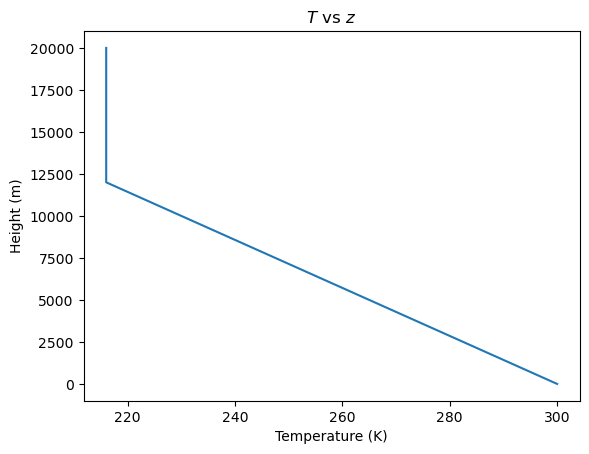

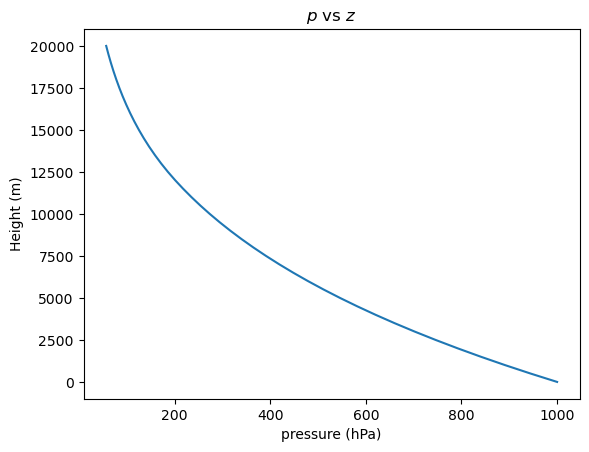

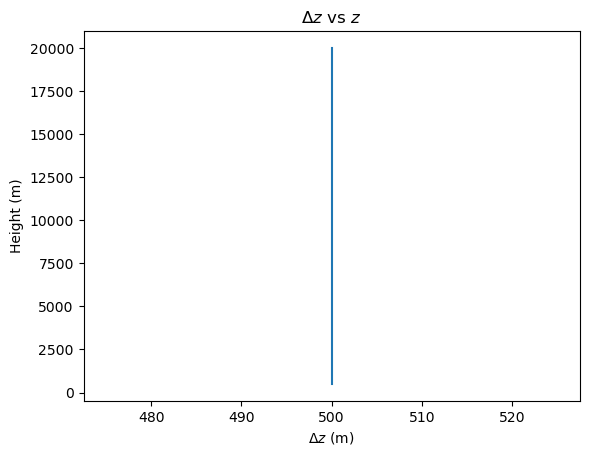

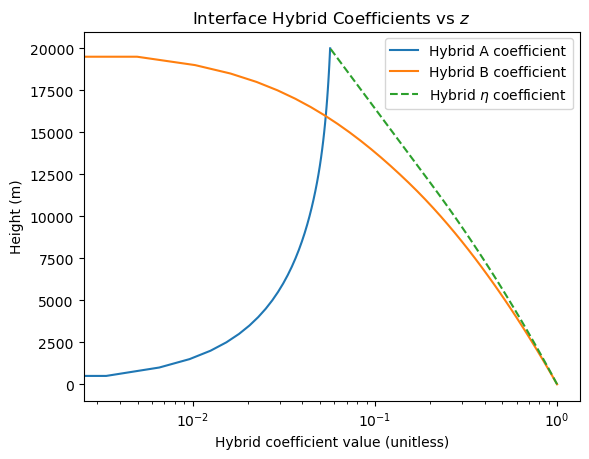

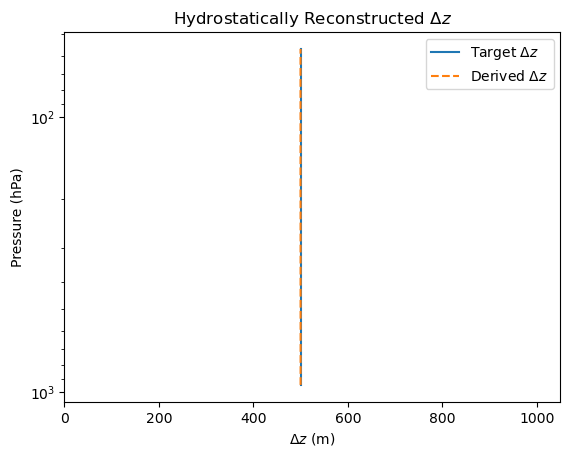

In [6]:
# produce diagnostics/plots
diagnostics = True

#Case
case = 3

# save file parameters
save = False
modname = f'TEST_case{case}_dz500m'
desc = 'z_top 20 km, uniform dz 500 m, derived with Gamma 7e-3 K/m, T0 300 K tropo and isothermal strat above 12 km'
attribution = 'DCMIP 2025'
creator = 'Nicholas Androski'
output_dir = ''

# Physical Constants
g = 9.80616 # Gravitational acceleration (ms^{-2})
Rd = 287.04  # Universal gas constant

# Hybrid transition
c = 1 # power used for eta coord calc
# Transition exponent between p0 and ps
# c=1 resembles the sigma-coordinate system
# c=2 allows a more gradual transition from
# contour-following to flat pressure levels
p0 = 1e5 # ref pressure in Pa

# case 1 specific
if case == 1:
    dz_min      = 100.            # minimum dz in m.
    dz_max      = 400.            # maximum dz in m.
    z_top       = 40.0e3          # Height of model top in m.
    dz_slope    = 700.0 / 21.0e3  # Rate of increase of dz. 
    z_trop      = 20.0e3          # height of the tropopause in m.
    Gamma       = 0.005           # Tropospheric Lapse rate in K/m.
    Gamma_strat = -0.005          # Stratospheric Lapse rate in K/m.
    T_surf      = 300.            # Temperature at the surface in K.

    z_i = dcmip_case1_z(z_top, dz_max, dz_min, dz_slope)
    p_from_z = partial(p_from_z_lapse_tropo_lapse_strat,Gamma_trop=Gamma,
                                                        T_surf=T_surf,
                                                        Gamma_strat=Gamma_strat,
                                                        z_trop = z_trop,
                                                        PS=p0,
                                                        zs=0)
    if diagnostics:
      T_from_p = partial(T_from_p_lapse_tropo_lapse_strat,Gamma_trop=Gamma,
                                                        T_surf=T_surf,
                                                        Gamma_strat=Gamma_strat,
                                                        z_trop = z_trop,
                                                        PS=p0,
                                                        zs=0)
      T_from_z = partial(T_from_z_lapse_tropo_lapse_strat,Gamma_trop=Gamma,
                                                        T_surf=T_surf,
                                                        Gamma_strat=Gamma_strat,
                                                        z_trop = z_trop,
                                                        zs=0)

# case 2 specific
if case == 2:
    dz_min = 300.  # min vertical spacing (m)
    dz_max = 1000. # max vertical spacing (m)
    z_top = 30000. # Model top (m)
    h0 = 1500.     # Mountain height
    T0 = 288.      # Isothermal temperature (K)

    z_i = dcmip_case2_z(z_top,dz_min,dz_max,h0,fact=1.02)
    p_from_z = partial(p_from_z_isothermal,T0=T0,PS=p0,zs=0)

    if diagnostics:
      T_from_p = partial(T_from_p_isothermal,T0=T0)
      T_from_z = partial(T_from_z_isothermal,T0=T0)


#case 3 specific
if case == 3:
    dz = 500. # uniform vertical spacing (m)
    z_top = 20000. # Model top (m)
    T0 = 300. # surface temp (K)
    Gamma = 7.e-3 # Lapse Rate in K/m
    strat = True # if True use a isothermal stratosphere starting at z_trop
    # if False uses only an troposphere with constant lapse rate
    z_trop = 12000.

    z_i = uniform_z(z_top,dz,zs=0)
    if strat:
      p_from_z = partial(p_from_z_lapse_tropo_isothermal_strat,Gamma=Gamma,T0=T0,
                                                       z_trop=z_trop,PS=p0,zs=0)
    else:
      p_from_z = partial(p_from_z_lapse_tropo,Gamma=Gamma,T0=T0,PS=p0,zs=0)

    if diagnostics:
      if strat:
        T_from_p = partial(T_from_p_lapse_tropo_isothermal_strat,Gamma=Gamma,
                          T0=T0,z_trop=z_trop,PS = p0, zs = 0)
        T_from_z = partial(T_from_z_lapse_tropo_isothermal_strat,Gamma=Gamma,
                          T0=T0,z_trop=z_trop, zs = 0)
      else:
        T_from_p = partial(T_from_p_lapse_tropo,Gamma=Gamma,
                          T0=T0,PS = p0)
        T_from_z = partial(T_from_z_lapse_tropo,Gamma=Gamma,
                          T0=T0, zs = 0)

ilev,lev,hyai,hybi,hyam,hybm = gen_coeff(z_i, p_from_z,p0=p0,c=c)

if save:
  save_coeff_to_nc(ilev, lev, hyai, hybi, hyam, hybm, p0,
                           output_dir, modname,desc,
                           attribution, creator,
                           overwrite=True)
if diagnostics:
  #plot a bunch of stuff
  dz = np.diff(z_i)
  z_m = z_i[:-1] + dz
  p = p_from_z(z_i)
  p_m = p_from_z(z_m)
  T = T_from_z(z_i)

  # assumed temperature profile
  plt.figure()
  plt.title(r"$T$ vs $z$")
  plt.ylabel("Height (m)")
  plt.xlabel("Temperature (K)")
  plt.plot(T, z_i)

  # p from z function
  plt.figure()
  plt.title(r"$p$ vs $z$")
  plt.ylabel("Height (m)")
  plt.xlabel("pressure (hPa)")
  plt.plot(p/100, z_i)

  # computed dz's for case
  plt.figure()
  plt.title(r"$\Delta z$ vs $z$")
  plt.ylabel("Height (m)")
  plt.xlabel(r"$\Delta z$ (m)")
  plt.plot(dz, z_m)

  # computed hybrid coeffs
  plt.figure()
  plt.title("Interface Hybrid Coefficients vs $z$")
  plt.ylabel("Height (m)")
  plt.xlabel("Hybrid coefficient value (unitless)")
  plt.plot(hyai, z_i, label = "Hybrid A coefficient")
  plt.plot(hybi, z_i, label = "Hybrid B coefficient")
  plt.plot(ilev/1000, z_i, label = r"Hybrid $\eta$ coefficient", linestyle="--")
  plt.xscale("log")
  plt.legend()

  # hydrostatic reconstruction of dz from hybrid coefficients
  plt.figure()
  plt.title(rf"Hydrostatically Reconstructed $\Delta z$")
  dz_hydro = recover_dz_from_coeff(hyai,hybi,hyam,hybm,p0,T_from_p)
  plt.plot(dz, p_m/100, label=r"Target $\Delta z$")
  plt.plot(dz_hydro, p_m/100, label=r"Derived $\Delta z$", linestyle="--")
  plt.xlim(0, 1050)
  plt.legend()
  plt.yscale("log")
  plt.xlabel(r"$\Delta z$ (m)")
  plt.ylabel("Pressure (hPa)")
  plt.gca().invert_yaxis()